<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200404_mnist/mnist_withGPUtfds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import os, sys
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)
print(tfds.__version__)

2.2.0-rc2
2.1.0


# Import data

In [0]:
(ds_train, ds_dev, ds_test), info = tfds.load('mnist', split=('train[:90%]', 'train[90%:]', 'test')
    , shuffle_files=True, with_info=True, as_supervised=True)
print(info)
n_train, n_dev, n_test = len(list(ds_train)), len(list(ds_dev)), len(list(ds_test))
print('no. of data for train, dev, test', n_train, n_dev, n_test)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

no. of data for train, dev, test 54000 6000 10000


Label: 4 Image Max Value: 255


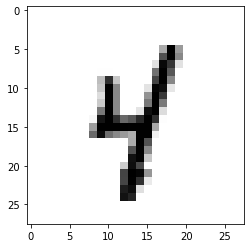

In [0]:
# check data structure
for img, label in ds_train.take(1):
    image = img.numpy().squeeze()
    label = label.numpy()

    print("Label: {}".format(label), "Image Max Value: {}".format(image.max()))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()

# Pre-processing

In [0]:
def preprocessor(imgs, labels):
    imgs = tf.cast(imgs, tf.float32)
    imgs /= 255.0
    return imgs, labels

In [0]:
ds_train = ds_train.map(preprocessor).batch(128)
ds_dev = ds_dev.map(preprocessor).batch(128)
ds_test = ds_test.map(preprocessor)

# Modeling

In [0]:
def getModel():
    model = tf.keras.Sequential(
        [tf.keras.layers.Conv2D(16, kernel_size=3)
        , tf.keras.layers.Conv2D(32, kernel_size=3)
        , tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(128, activation='relu')
        , tf.keras.layers.Dense(10, activation='softmax')
        ]
    )
    model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['acc'])
    return model

In [0]:
# Tensorboards callback setting
# Clear logs prior to logging data.
# !rm -rf logs

# Create log directory
# logdir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
%%time

model = getModel()

# %tensorboard --logdir logs
history = model.fit(ds_train, epochs=5, validation_data=ds_dev, verbose=1
                    # , callbacks=[tensorboard_callback]
                    )

Epoch 1/5
422/422 [==============================] - 18s 43ms/step - loss: 0.2322 - acc: 0.9301 - val_loss: 0.1282 - val_acc: 0.9600
Epoch 2/5
422/422 [==============================] - 17s 41ms/step - loss: 0.0989 - acc: 0.9697 - val_loss: 0.1178 - val_acc: 0.9637
Epoch 3/5
422/422 [==============================] - 18s 41ms/step - loss: 0.0642 - acc: 0.9816 - val_loss: 0.1049 - val_acc: 0.9697
Epoch 4/5
422/422 [==============================] - 17s 41ms/step - loss: 0.0426 - acc: 0.9866 - val_loss: 0.1066 - val_acc: 0.9715
Epoch 5/5
422/422 [==============================] - 18s 42ms/step - loss: 0.0339 - acc: 0.9890 - val_loss: 0.1112 - val_acc: 0.9698
CPU times: user 1min 45s, sys: 50 s, total: 2min 35s
Wall time: 1min 34s


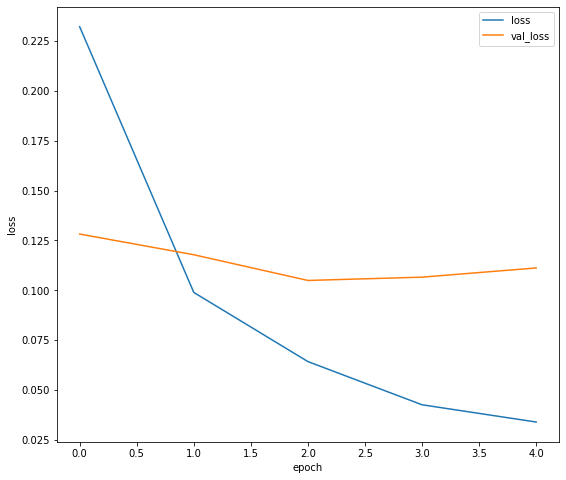

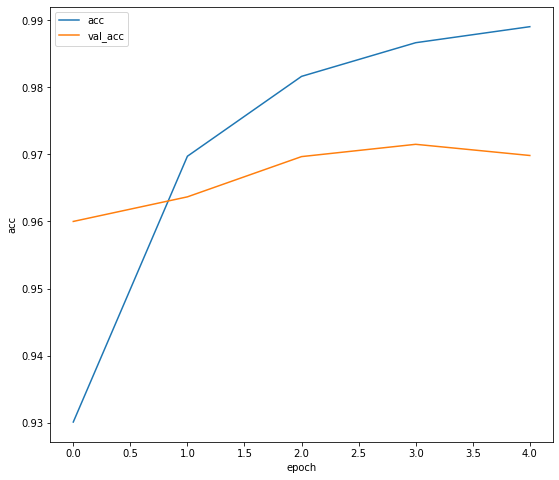

In [0]:
def plot_history(history):
    hist = history.history
    for key in ['loss', 'acc']:
        plt.figure(figsize=(9, 8))
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

%matplotlib inline
plot_history(history)

# Model Evaluation

In [0]:
eval = model.evaluate(ds_test.batch(128))
print('Test data: Loss = {}, Accuracy = {}'.format(eval[0], eval[1]))
print('Right Prediction: {}, Wrong Prediction: {}'.format(eval[1]*n_test, (1.0-eval[1])*n_test))

79/79 [==============================] - 3s 34ms/step - loss: 0.1137 - acc: 0.9693
Test data: Loss = 0.11373654752969742, Accuracy = 0.9692999720573425
Right Prediction: 9692.999720573425, Wrong Prediction: 307.0002794265747


In [0]:
%%time

test_labels = [x.numpy() for x in ds_test.map(lambda _, label: label)]
test_pred = model.predict(ds_test.batch(128)).argmax(axis=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7f51dba91158>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7f51dba91158>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7f51dba91158>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 8.37 s, sys: 3.11 s, total: 11.5 s
Wall time: 6.59 s


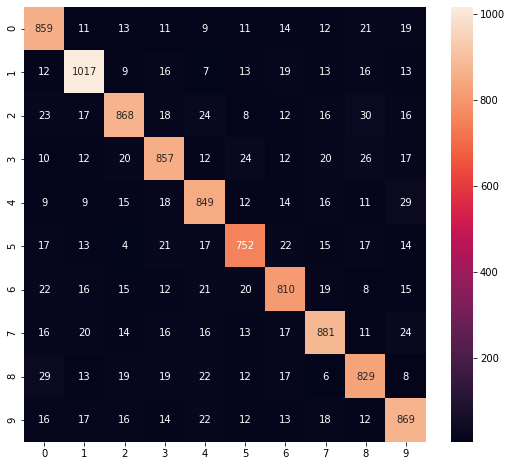

In [0]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
fig = plt.figure(figsize=(9, 8))
sns.heatmap(pd.DataFrame(cm, range(10), range(10)), annot=True, fmt='d')

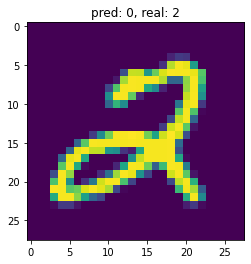

In [0]:
iimg = np.where(test_labels!=test_pred)[0][0]
for img, label in ds_test.skip(iimg).take(1):
    plt.imshow(img.numpy().squeeze() * 255.0)
    plt.title('pred: {}, real: {}'.format(test_pred[iimg],test_labels[iimg]))